Import necessary libraries

In [389]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix
import sklearn.metrics as mt   
import seaborn as sns
from sklearn.metrics import classification_report

Load data from source into a Pandas Dataframe

In [390]:
pd.set_option('display.width', 100)
pd.set_option('precision', 3)

In [391]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
names=['code', 'cl_thick', 'c_size', 'c_shape', 'marg_adh', 's_ep_c_size', 
       'b_nuclei', 'b_chromatin', 'n_nucleoli', 'mitoses', 'diag'] 
data = pandas.read_csv(url, names=names)

In [392]:
data.drop('code', axis=1, inplace=True)
data.head()

,cl_thick,c_size,c_shape,marg_adh,s_ep_c_size,b_nuclei,b_chromatin,n_nucleoli,mitoses,diag
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [393]:
data.shape

(699, 10)

In [394]:
data.dtypes

cl_thick        int64
c_size          int64
c_shape         int64
marg_adh        int64
s_ep_c_size     int64
b_nuclei       object
b_chromatin     int64
n_nucleoli      int64
mitoses         int64
diag            int64
dtype: object

In [395]:
data.describe()

,cl_thick,c_size,c_shape,marg_adh,s_ep_c_size,b_chromatin,n_nucleoli,mitoses,diag
count,699.000,699.000,699.000,699.000,699.000,699.000,699.000,699.000,699.000
mean,4.418,3.134,3.207,2.807,3.216,3.438,2.867,1.589,2.690
std,2.816,3.051,2.972,2.855,2.214,2.438,3.054,1.715,0.951
min,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2.000
25%,2.000,1.000,1.000,1.000,2.000,2.000,1.000,1.000,2.000
50%,4.000,1.000,1.000,1.000,2.000,3.000,1.000,1.000,2.000
75%,6.000,5.000,5.000,4.000,4.000,5.000,4.000,1.000,4.000
max,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,4.000


In [396]:
pd.unique(data.b_nuclei.ravel())

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'], dtype=object)

test handling of '?'

In [448]:
dx = data
#Convert the '?' to some easily identified value that can be converted to an integer
dx['b_nuclei'] = dx['b_nuclei'].apply(lambda x: x if x != '?' else '-1')
dx.head(50)
#convert the column to an integer
dx.b_nuclei = dx.b_nuclei.astype('int')
#get the mean of all of the values, EXCEPT for the value that we used in place of the '?'
mean = int(round(dx[dx.b_nuclei != -1].b_nuclei.mean()))
print(mean)
dx['b_nuclei'] = dx['b_nuclei'].apply(lambda x: x if x != -1 else mean)
pd.unique(dx.b_nuclei.ravel())

4


array([ 1, 10,  2,  4,  3,  9,  7,  5,  8,  6])

In [438]:
pd.unique(dx.b_nuclei.ravel())

array(['1', '10', '2', '4', '3', '9', '7', '-1', '5', '8', '6'], dtype=object)

In [397]:
data_no_missing = data[data.b_nuclei != '?']
data_no_missing.b_nuclei = data_no_missing.b_nuclei.astype('int')
pd.unique(data_no_missing.b_nuclei.ravel())

array([ 1, 10,  2,  4,  3,  9,  7,  5,  8,  6])

In [398]:
data_missing = data[data.b_nuclei == '?']
data_missing.b_nuclei = int(round(data_missing.b_nuclei.mean()))
pd.unique(data_missing.b_nuclei.ravel())

array([4])

In [399]:
data_clean = pd.concat([data_no_missing, data_missing])
pd.unique(data_clean.b_nuclei.ravel())

array([ 1, 10,  2,  4,  3,  9,  7,  5,  8,  6])

In [400]:
data_clean.shape

(699, 10)

In [401]:
array = data_clean.values
X = array[:,0:9]
#pd.unique(X)

In [402]:
Y = array[:,9]
pd.unique(Y)

array([2, 4])

In [403]:
# data_clean['diag'].replace([2, 4], [0, 1], inplace=True)
# data_clean.head()

In [404]:
daignosis_map = {2:0,4:1}
data_clean['diag'] = data_clean['diag'].map(daignosis_map)
data_clean.head()

,cl_thick,c_size,c_shape,marg_adh,s_ep_c_size,b_nuclei,b_chromatin,n_nucleoli,mitoses,diag
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


In [405]:
out_count = data_clean.groupby('diag').size()
print(out_count)

diag
0    458
1    241
dtype: int64


In [406]:
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed) 
model = LogisticRegression()
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring='accuracy') 
print("Accuracy: %.3f (%.3f)") % (results.mean(), results.std())
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring='log_loss') 
print("Accuracy: %.3f (%.3f)") % (results.mean(), results.std())
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring='roc_auc') 
print("Accuracy: %.3f (%.3f)") % (results.mean(), results.std())

Accuracy: 0.964 (0.036)
Accuracy: -0.111 (0.060)
Accuracy: 0.993 (0.009)


In [407]:
#NOT WORKING
def cross_validation_score(mod, X, Y, kfold, scoring):
    score = cross_validation.cross_val_score(mod, X, Y, cv=kfold, scoring=scoring) 
    return (("Scoring: %s; Accuracy: %.3f (%.3f)") % (scoring, score.mean(), score.std()), score)

In [408]:
cross_val_scoring = ['accuracy','log_loss','roc_auc','mean_absolute_error','mean_squared_error','r2']
for scoring in cross_val_scoring:    
    result = cross_validation_score(model, X, Y, kfold, scoring)
    print(result[0])

Scoring: accuracy; Accuracy: 0.964 (0.036)
Scoring: log_loss; Accuracy: -0.111 (0.060)
Scoring: roc_auc; Accuracy: 0.993 (0.009)
Scoring: mean_absolute_error; Accuracy: -0.036 (0.036)
Scoring: mean_squared_error; Accuracy: -0.036 (0.036)
Scoring: r2; Accuracy: 0.843 (0.140)


Training the model

In [409]:
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=seed)
model = LogisticRegression()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
matrix = confusion_matrix(Y_test, predicted)
print(matrix)

[[147   5]
 [  3  76]]


In [410]:
147

147

In [411]:
predicted[predicted == 0].size

150

In [412]:
predicted[predicted == 1].size

81

In [413]:
predicted

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0])

In [414]:
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

          0       0.98      0.97      0.97       152
          1       0.94      0.96      0.95        79

avg / total       0.97      0.97      0.97       231



In [415]:
def printModelSummary(actual, predicted):
    '''
        Method to print out model summaries
    '''
    print('Overall accuracy of the model is {0:.2f} percent'\
        .format(
            (actual == predicted).sum() / \
            len(actual) * 100))
    print('Classification report: \n', 
        mt.classification_report(actual, predicted))
    print('Confusion matrix: \n', 
        mt.confusion_matrix(actual, predicted))
    print('ROC: ', mt.roc_auc_score(actual, predicted))


In [416]:
printModelSummary(Y_test, predicted)

Overall accuracy of the model is 0.00 percent
('Classification report: \n', '             precision    recall  f1-score   support\n\n          0       0.98      0.97      0.97       152\n          1       0.94      0.96      0.95        79\n\navg / total       0.97      0.97      0.97       231\n')
('Confusion matrix: \n', array([[147,   5],
       [  3,  76]]))
('ROC: ', 0.96456528980679546)


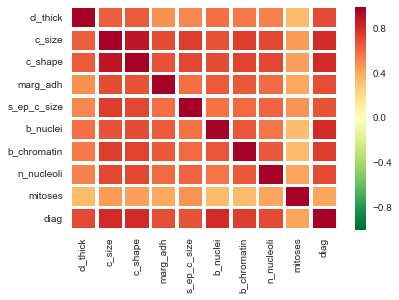

In [417]:
correlations = data_clean.corr(method='pearson')
sns.heatmap(correlations, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0, linewidths=2.5)

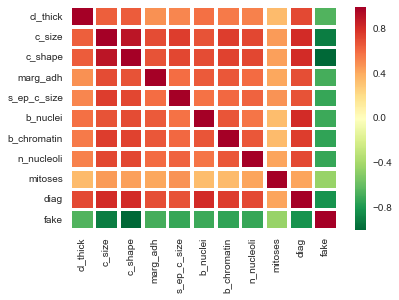

In [423]:
import random
data_x = data_clean
data_x['fake'] = data_x.c_shape * -1
corrx = data_x.corr()
sns.heatmap(corrx, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0, linewidths=2.5)